# Machine Learning for History

## BACKGROUND
The collectivization of agriculture in Romania took place in the early years of the Communist regime in the late 1950s and early 1960s. Upon joining the collective farm, the peasant and his family turned over their land, farm implements and livestock to the collective enterprise. In this kind of enterprise the farmers did not share the profits 
but were paid wages according to how many days they worked on the farm. 

## PROBLEM
* We have data on 5342 villages (35% of the entire country) from local archives in Romania  which were collectivized under communism in 1962 and 
* We would like to make educated guesses to ascertain which villages were collectivized and which ones were not
* We know that collectivization was heavily determing by geographic factors: how mountaineous and how fertile land is 

## SOLUTION
We use machine learning to predict which villages were collectivized and which ones were not

In [1]:
#Importing relevant libraries
import geopandas as gpd
import pandas as pd
import numpy as np
import fiona
from sklearn import preprocessing

In [2]:
#Making map to show the problem
#Reading the shapefile
fp = "data/soil.gdb"
#fiona.listlayers('data/soil.gdb')
soil = gpd.read_file(fp, driver="FileGDB", layer='all_villages')
#for col in soil.columns: 
#    print(col)

In [3]:
#Creating variable to indicate presence of data
soil["data_available"]="Data Not Available"
soil.loc[soil['collectivized_1962'].isin(["Yes", "No", "dnk"]), \
         'data_available'] = "Data Available"

In [4]:
#Creating unique ID
soil['UID'] = list(range(soil.shape[0]))
soil

,Input_FID,Join_Count,TARGET_FID,uniqueID,raion_1960,raion_1962,commune_1960,commune_1962,village_1960,village_1962,...,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,sq_mean,sq_mean_point,geometry,data_available,UID
0,453.0,1.0,453.0,113.0,None,Horezu,None,Roești,None,Frasina,...,1,1,1,1,1,NaN,1.000000,"MULTIPOLYGON Z (((24.07293 44.91715 0.00000, 2...",Data Available,0
1,451.0,1.0,451.0,111.0,None,Horezu,None,Roești,None,Cueni,...,1,1,1,1,1,NaN,1.000000,"MULTIPOLYGON Z (((24.10050 44.89461 0.00000, 2...",Data Available,1
2,455.0,1.0,455.0,108.0,None,Horezu,None,Roești,None,Ciocîltei,...,1,1,1,1,1,NaN,1.000000,"MULTIPOLYGON Z (((24.09667 44.94828 0.00000, 2...",Data Available,2
3,457.0,1.0,457.0,109.0,None,Horezu,None,Roești,None,Bălașa,...,1,1,1,1,1,NaN,1.000000,"MULTIPOLYGON Z (((24.06904 44.94153 0.00000, 2...",Data Available,3
4,452.0,1.0,452.0,110.0,None,Horezu,None,Roești,None,Băjenari,...,1,1,1,1,1,NaN,1.000000,"MULTIPOLYGON Z (((24.08326 44.93335 0.00000, 2...",Data Available,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7419,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1,1,1,1,1,1.000000,1.000000,"MULTIPOLYGON Z (((26.96038 46.07917 0.00000, 2...",Data Not Available,7419
7420,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1,1,2,1,1,1.142857,1.142857,"MULTIPOLYGON Z (((27.23861 45.96791 0.00000, 2...",Data Not Available,7420
7421,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1,1,1,1,1,1.000000,1.000000,"MULTIPOLYGON Z (((27.20619 46.07192 0.00000, 2...",Data Not Available,7421
7422,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1,1,1,1,1,1.000000,1.000000,"MULTIPOLYGON Z (((27.36554 46.13712 0.00000, 2...",Data Not Available,7422


## Step 0: Illustrating the problem
The following map illustrates our issue. Mapping the villages for which we have data and the ones for which we do not

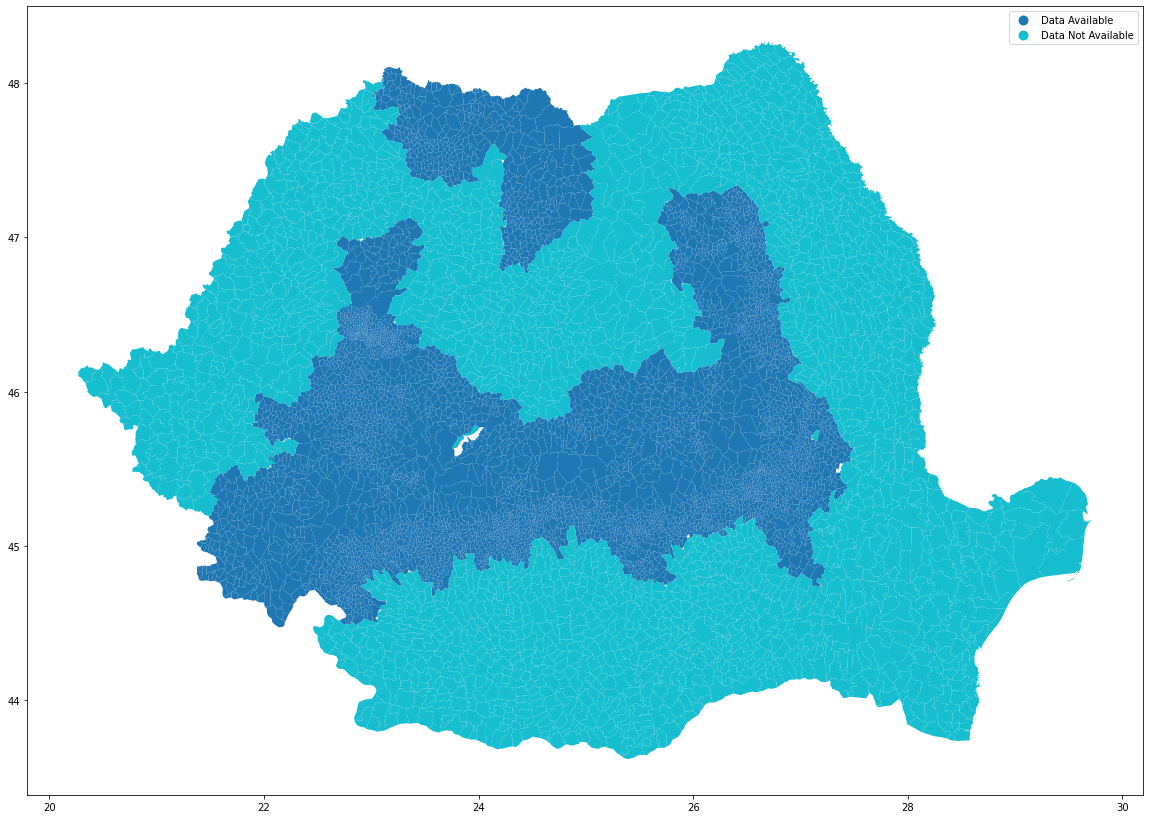

In [5]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
f, ax = plt.subplots()
x_fig = soil.plot(ax=ax, column = "data_available", legend=True)
x_fig

## Step1: Preprocessing the Data

In [6]:
#Defining X and Y coordinates
soil["point_x"] = soil.centroid.x
soil["point_y"] = soil.centroid.y

<ipython-input-6-95d2269694d2>:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  soil["point_x"] = soil.centroid.x
<ipython-input-6-95d2269694d2>:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  soil["point_y"] = soil.centroid.y


In [7]:
#Defining the treatment
#1 - villages that were collectivized
#0 - villages that were not collectivized
#soil['collectivized_1962']
soil["collect"]=None
soil.loc[soil['collectivized_1962'] == "Yes", 'collect'] = 1
soil.loc[soil['collectivized_1962'] == "No", 'collect'] = 0
#soil.loc[soil['collectivized_1962'] == "dnk", 'collect'] = None
soil["collect"]

0          1
1          1
2          1
3          1
4          1
        ... 
7419    None
7420    None
7421    None
7422    None
7423    None
Name: collect, Length: 7424, dtype: object

In [8]:
#Selecting the villages where the treat is none - for which I need predictions
#Selecting the geographic variables that are relevant:
#-elev = elevation
#-slope = slope
#-tavg_mean = average temperature in a year
#-prec_mean = average precipitation in a year
#-sq1_point = soil nutrient availability frm FAO
#-sq2_point = soil nutrient retention capacity
#-sq3_point = soil rooting conditions
#-sq4_point = soil oxygen availability to roots
#-sq5_point = soil excell salts
#-sq6_point = soil excell capacity
#-sq7_point = soil workability
#-sq_mean_point = avearage of all soil characteristics
df_na = soil.loc[soil.collect.isnull(), ['collect', 'elev', 'slope', 
                                  'tavg_mean', 'prec_mean',
                                    'sq1_point', 'sq2_point', 'sq3_point',
                                    'sq4_point', 'sq5_point', 'sq6_point', 'sq7_point',
                                    'point_x', 'point_y', 'UID']]

#Dropping any observations where any of the variables might be missing
X_new = df_na[['elev', 'slope','tavg_mean', 'prec_mean',
                  'sq1_point', 'sq2_point', 'sq3_point',
                  'sq4_point', 'sq5_point', 'sq6_point', 'sq7_point',
              'point_x', 'point_y', 'UID']]
X_new= X_new.dropna()
X_new

,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID
138,308.357143,1.404589,9.467262,47.529762,1,1,1,2,1,1,1,25.924836,45.101543,138
139,300.071429,1.100574,9.551190,47.425595,1,1,1,1,1,1,1,25.902736,45.086632,139
140,252.000000,0.659051,9.761111,47.250000,1,1,1,2,1,1,1,25.949930,45.080627,140
206,590.250000,2.099852,8.335417,51.031250,1,1,1,1,1,1,1,25.639025,45.172690,206
207,504.888889,2.878028,8.598148,50.694444,1,1,1,1,1,1,1,25.672223,45.171875,207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7419,264.869919,1.537478,9.388279,43.844851,1,1,1,1,1,1,1,27.083658,46.037755,7419
7420,82.288889,0.750335,10.075741,42.629630,1,1,1,1,2,1,1,27.194820,46.002826,7420
7421,231.278912,1.368029,9.493651,43.541950,1,1,1,1,1,1,1,27.090595,46.082302,7421
7422,170.074468,2.059208,9.648050,43.706560,1,1,1,1,1,1,1,27.307082,46.152678,7422


In [9]:
#Selecting the actual data where the treatment is not null
#Remember that the treatment is null in the prediction data - df_na
df = soil.loc[soil.collect.notna(), ['collect', 'elev', 'slope', 
                                  'tavg_mean', 'prec_mean',
                                    'sq1_point', 'sq2_point', 'sq3_point',
                                    'sq4_point', 'sq5_point', 'sq6_point', 'sq7_point',
                                    'point_x', 'point_y', 'UID']]

df["collect"]=df["collect"].astype(int)
df=df.dropna()
df.collect.describe()
df

,collect,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID
0,1,320.000000,0.672766,10.000000,55.027778,1,1,1,1,1,1,1,24.064119,44.922811,0
1,1,393.000000,0.961969,9.946667,54.866667,1,1,1,1,1,1,1,24.085466,44.887799,1
2,1,393.500000,1.735723,9.868750,55.145833,1,1,1,1,1,1,1,24.084851,44.944439,2
3,1,324.500000,1.223942,9.912500,55.097222,1,1,1,1,1,1,1,24.059126,44.935628,3
4,1,383.500000,2.723302,10.041667,54.736111,1,1,1,1,1,1,1,24.081036,44.922596,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5450,1,601.466667,6.259692,8.651111,56.833333,2,2,3,1,1,1,3,23.033889,45.614787,5450
5451,1,543.368421,5.731974,8.707456,56.114035,2,2,3,1,1,1,3,23.068249,45.648021,5451
5452,1,376.285714,2.230796,9.613690,53.208333,2,1,1,2,1,1,1,23.053693,45.671500,5452
5453,1,262.000000,0.734564,9.980357,51.511905,1,1,1,2,1,1,1,22.986297,45.693762,5453


## Step 2: Preparing Data for Machine Learning

In [10]:
#Step1: Defining X and Y
# store feature matrix in "X"
X = df[['elev', 'slope','tavg_mean', 'prec_mean',
        'sq1_point', 'sq2_point', 'sq3_point', 'sq4_point', 
        'sq5_point', 'sq6_point', 'sq7_point',
       'point_x', 'point_y']]
y = df[['collect']]

#Counting 1 and 0 in the dependning variable
unique, counts = np.unique(df['collect'], return_counts=True)
dict(zip(unique, counts))

{0: 2557, 1: 2781}

In [11]:
#Step2: Scaling
#Scaling (standardizing) all the independent variables
#To ensure that the gradient descent moves smoothly towards the minima and 
#that the steps for gradient descent are updated at the same rate for all 
#the features, we scale the data before feeding it to the model.
#Scaling is good when data is vastly spread out.
from sklearn import preprocessing
X_scaled = preprocessing.scale(X)
X_scaled

array([[-0.6124705 , -1.1498822 ,  0.90375905, ..., -0.52978043,
        -0.32049595, -1.12747516],
       [-0.35190821, -1.00147228,  0.87167094, ..., -0.52978043,
        -0.30714794, -1.17177898],
       [-0.35012354, -0.604405  ,  0.82479221, ..., -0.52978043,
        -0.30753267, -1.10010688],
       ...,
       [-0.41156729, -0.35034851,  0.67133513, ..., -0.52978043,
        -0.9522843 , -0.18008328],
       [-0.8194926 , -1.11816972,  0.89194091, ..., -0.52978043,
        -0.99442537, -0.15191215],
       [ 0.98132768,  0.97974659, -0.38143668, ...,  2.41142388,
        -0.94786477, -0.24876047]])

## Step 3: Model Logistic

In [12]:
#Step3: Import the class
from sklearn.linear_model import LogisticRegression
# instantiate the model (using the default parameters)
logreg = LogisticRegression()
# fit the model with data
#.values will give the values in an array. (shape: (n,1)
#.ravel will convert that array shape to (n, )
logreg.fit(X_scaled, y.values.ravel())

LogisticRegression()

In [13]:
#Step4: simulate splitting a dataset of 1000 observations into 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False).split(range(1000))

In [14]:
#Step5: Cross Validation Score
from sklearn.model_selection import cross_val_score
scores_1000obs_10_folds = cross_val_score(logreg, X_scaled, y.values.ravel(), cv=10, scoring='accuracy')
print(scores_1000obs_10_folds)

[0.74719101 0.7340824  0.72097378 0.77340824 0.81273408 0.7659176
 0.78089888 0.76404494 0.70919325 0.70919325]


In [15]:
# use average accuracy as an estimate of out-of-sample accuracy
score_logistic = scores_1000obs_10_folds.mean()
score_logistic

0.7517637427886811

## Step4. Model Support Vector Machine

In [16]:
#Step3: Import the class
from sklearn import svm
# instantiate the model (using the default parameters)
clf = svm.SVC()
# fit the model with data
#.values will give the values in an array. (shape: (n,1)
#.ravel will convert that array shape to (n, )
clf.fit(X_scaled, y.values.ravel())

SVC()

In [17]:
#Step4: simulate splitting a dataset of 1000 observations into 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False).split(range(1000))

In [18]:
#Step5: Cross Validation Score
from sklearn.model_selection import cross_val_score
scores_1000obs_10_folds = cross_val_score(clf, X_scaled, y.values.ravel(), cv=10, scoring='accuracy')
print(scores_1000obs_10_folds)

[0.75842697 0.73782772 0.76404494 0.80149813 0.83520599 0.78651685
 0.81835206 0.79775281 0.7673546  0.73921201]


In [19]:
# use average accuracy as an estimate of out-of-sample accuracy
score_svc = scores_1000obs_10_folds.mean()
score_svc

0.7806192072292374

## Step5. Model Random Forest

In [20]:
#Step3: Import the class
from sklearn.ensemble import RandomForestClassifier
#See if changing max_depth optimizes accuracy.

rdf = RandomForestClassifier(max_depth=4, random_state=0)
# fit the model with data
#.values will give the values in an array. (shape: (n,1)
#.ravel will convert that array shape to (n, )
rdf.fit(X_scaled, y.values.ravel())

RandomForestClassifier(max_depth=4, random_state=0)

In [21]:
#Step4: simulate splitting a dataset of 1000 observations into 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False).split(range(1000))

In [22]:
#Step5: Cross Validation Score
from sklearn.model_selection import cross_val_score
scores_1000obs_10_folds = cross_val_score(rdf, X, y.values.ravel(), cv=10, scoring='accuracy')
print(scores_1000obs_10_folds)

[0.75842697 0.73033708 0.70411985 0.78089888 0.8164794  0.76779026
 0.77340824 0.75468165 0.74484053 0.70919325]


In [23]:
# use average accuracy as an estimate of out-of-sample accuracy
score_rdf = scores_1000obs_10_folds.mean()
score_rdf

0.7540176093204319

## Step6: Model Neural Networks

In [24]:
#Step3: Import the class
from sklearn.neural_network import MLPClassifier
# instantiate the model (using the default parameters)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,
                     hidden_layer_sizes=(5, 2), random_state=1,
                     max_iter=1000)
# fit the model with data
#.values will give the values in an array. (shape: (n,1)
#.ravel will convert that array shape to (n, )
# fit the model with data
clf.fit(X_scaled, y.values.ravel())

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=1000,
              random_state=1, solver='lbfgs')

In [25]:
#Step4: simulate splitting a dataset of 1000 observations into 10 folds
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, shuffle=False).split(range(1000))

In [26]:
#Step5: Cross Validation Score
from sklearn.model_selection import cross_val_score
scores_1000obs_10_folds = cross_val_score(clf, X_scaled, y.values.ravel(), cv=10, scoring='accuracy')
print(scores_1000obs_10_folds)

[0.77153558 0.74531835 0.76779026 0.79026217 0.84082397 0.76404494
 0.79213483 0.77715356 0.75422139 0.75609756]


In [27]:
# use average accuracy as an estimate of out-of-sample accuracy
score_nn = scores_1000obs_10_folds.mean()
score_nn

0.7759382619755325

## Step7: Model Neural Networks with Optimal Parameters - Gridsearch

In [31]:
#Larger Paramter Space
parameter_space = {
    #5, 2 means two hidden layers: 1st one with 5 nodes and 2nd with two
    'hidden_layer_sizes': [(5, 2), (20,20,20,20,20), (50,50,50), (50,100,50), (100,)],
    #tanh - hyperbolic tangent - function used to obtain the outcome of the network
    #relu - rectified linear unit 
    #Both useful because they are between 0 and 1
    'activation': ['tanh', 'relu'],
    #1.lbfgs - Broyden–Fletcher–Goldfarb–Shanno - determines the descent direction 
    #by preconditioning the gradient with curvature information
    #2.sgd - Stochastic gradient descent -  an iterative method for 
    #optimizing an objective function with suitable smoothness properties
    #3.adam - adaptive learning rate optimization algorithm that's been 
    #designed specifically for training deep neural networks. 
    'solver': ['lbfgs', 'sgd', 'adam'],
    #alpha - penalty (regularization term) parameter, biasing data towards 
    #particular values (such as small values near zero)
    'alpha': [0.0001, 0.05, 1, 2, 3, 4, 5, 10, 11, 12, 13, 14, 15],
    #‘constant’ is a constant learning rate given by ‘learning_rate_init’.
    #‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing
    'learning_rate': ['constant','adaptive'],
}

clf = MLPClassifier()

In [28]:
#Smaller Parameter Space
parameter_space = {
    #5, 2 means two hidden layers: 1st one with 5 nodes and 2nd with two
    #'hidden_layer_sizes': [(5, 2), (20,20,20,20,20), (50,50,50), (50,100,50), (100,)],
    'hidden_layer_sizes': [(5,), (75,), (100,), (150,)],
    #tanh - hyperbolic tangent - function used to obtain the outcome of the network
    'activation': ['tanh'],
    #1.lbfgs - good for small datasets
    'solver': ['lbfgs'],
    #alpha - penalty (regularization term) parameter, biasing data towards 
    #particular values (such as small values near zero)
    #We go by order of magnitude
    #'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 5, 10],
    'alpha': [1, 1.5, 2.0, 2.5, 3.0, 3.5, 4, 4.5, 5, 7.5, 10],
    #‘constant’ is a constant learning rate given by ‘learning_rate_init’.
    #‘adaptive’ keeps the learning rate constant to ‘learning_rate_init’ as long as training loss keeps decreasing
    'learning_rate': ['constant'],
}

clf = MLPClassifier()

In [29]:
#COMPUTATIONALY EXPENSIVE!!!
#Under current config - 5 mins
from sklearn.model_selection import GridSearchCV

grid = GridSearchCV(clf, parameter_space, n_jobs=-1, cv=10, verbose=2)
grid.fit(X_scaled, y.values.ravel())

Fitting 10 folds for each of 44 candidates, totalling 440 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 440 out of 440 | elapsed:  4.9min finished
/Users/bgpopescu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['tanh'],
                         'alpha': [1, 1.5, 2.0, 2.5, 3.0, 3.5, 4, 4.5, 5, 7.5,
                                   10],
                         'hidden_layer_sizes': [(5,), (75,), (100,), (150,)],
                         'learning_rate': ['constant'], 'solver': ['lbfgs']},
             verbose=2)

In [30]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.7920466443212402
{'activation': 'tanh', 'alpha': 5, 'hidden_layer_sizes': (150,), 'learning_rate': 'constant', 'solver': 'lbfgs'}


In [47]:
#Using randomized Gridsearcg - more efficient
#Takes about one minute
from sklearn.model_selection import RandomizedSearchCV
clf = MLPClassifier(max_iter=200)
grid = RandomizedSearchCV(clf, parameter_space, n_jobs=-1, cv=10, verbose=2)
# fit the model with data
#.values will give the values in an array. (shape: (n,1)
#.ravel will convert that array shape to (n, )
grid.fit(X_scaled, y.values.ravel())

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.3min finished
/Users/bgpopescu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


RandomizedSearchCV(cv=10, estimator=MLPClassifier(), n_jobs=-1,
                   param_distributions={'activation': ['tanh'],
                                        'alpha': [1, 1.5, 2.0, 2.5, 3.0, 3.5, 4,
                                                  4.5, 5, 7.5, 10],
                                        'hidden_layer_sizes': [(5,), (75,),
                                                               (100,), (150,)],
                                        'learning_rate': ['constant'],
                                        'solver': ['lbfgs']},
                   verbose=2)

In [49]:
# examine the best model
print(grid.best_score_)
print(grid.best_params_)

0.7830529614717063
{'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (100,), 'alpha': 5, 'activation': 'tanh'}


In [31]:
score_nn=grid.best_score_
score_nn

0.7920466443212402

## Step8: Comparing all the scores

(0.2, 1.0)

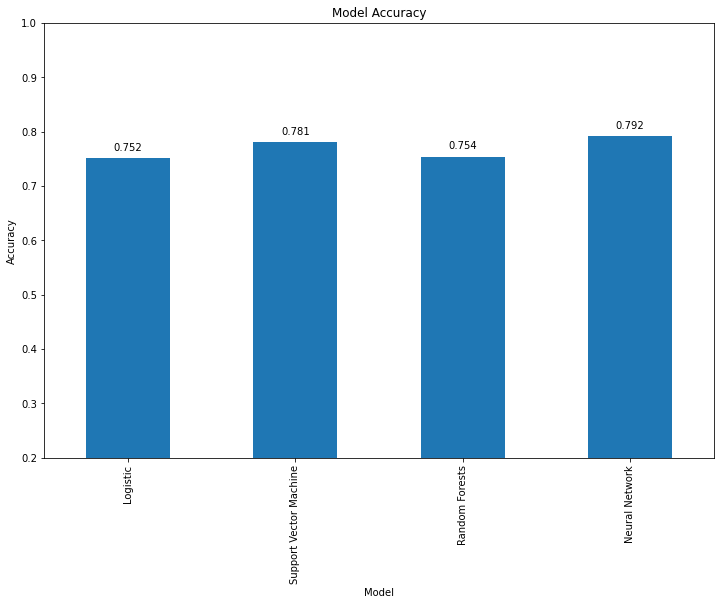

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Bring some raw data.
score_no = [score_logistic, score_svc, score_rdf, score_nn]
labels = ["Logistic", "Support Vector Machine", "Random Forests", "Neural Network"]
freq_series = pd.Series(score_no)

# Plot the figure.
plt.figure(figsize=(12, 8))
ax = freq_series.plot(kind='bar')
ax.set_title('Model Accuracy')
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_xticklabels(labels)

rects = ax.patches

# Make labels.
labels = ["label%d" % i for i in range(len(rects))]

for rect, label, score in zip(rects, labels, score_no):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height + 0.01, round(score,3),
            ha='center', va='bottom')
    
plt.ylim([0.2, 1])

## Step9: Making predictions out of sample with the model with best accuracy

In [33]:
#Neural Networks have the best accuracy 
#I will use neural networks to make predictions for the data outside.

#Define model with best parameters
#AUTOMATICALLY FEEDING BEST PARAMETERS TO MODEL
clf = MLPClassifier(**grid.best_params_)

In [38]:
#Scaling (standardizing) all the independent variables
#To ensure that the gradient descent moves smoothly towards the minima and 
#that the steps for gradient descent are updated at the same rate for all 
#the features, we scale the data before feeding it to the model.
#Scaling is good when data is vastly spread out.
X_new_scaled = preprocessing.scale(X_new.drop("UID", axis=1))
X_new_scaled

array([[ 0.27087196,  0.08729447, -0.18117908, ..., -0.31096933,
         0.35919367, -0.51195182],
       [ 0.23489874, -0.16365396, -0.1286    , ..., -0.31096933,
         0.34795569, -0.52393053],
       [ 0.026192  , -0.52810724,  0.00290987, ..., -0.31096933,
         0.37195409, -0.52875465],
       ...,
       [-0.0637706 ,  0.05711631, -0.16464712, ..., -0.31096933,
         0.95199192,  0.27595038],
       [-0.32949559,  0.62764749, -0.06792021, ..., -0.31096933,
         1.06207762,  0.33248781],
       [-0.37863539,  0.63752932,  0.03313008, ..., -0.31096933,
         1.09274706,  0.29540348]])

In [39]:
# make a prediction on out-of-sample data
clf.fit(X_scaled, y.values.ravel())

/Users/bgpopescu/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='tanh', alpha=5, hidden_layer_sizes=(150,),
              solver='lbfgs')

In [40]:
y_hats = clf.predict(X_new_scaled)

In [41]:
#Counting 0 and 1 in predictions
unique, counts = np.unique(y_hats, return_counts=True)
dict(zip(unique, counts))

{0: 1080, 1: 1001}

In [42]:
#Adding predictions to the out-of-sample data
X_new['preds'] = y_hats
X_new

,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID,preds
138,308.357143,1.404589,9.467262,47.529762,1,1,1,2,1,1,1,25.924836,45.101543,138,1
139,300.071429,1.100574,9.551190,47.425595,1,1,1,1,1,1,1,25.902736,45.086632,139,0
140,252.000000,0.659051,9.761111,47.250000,1,1,1,2,1,1,1,25.949930,45.080627,140,0
206,590.250000,2.099852,8.335417,51.031250,1,1,1,1,1,1,1,25.639025,45.172690,206,0
207,504.888889,2.878028,8.598148,50.694444,1,1,1,1,1,1,1,25.672223,45.171875,207,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7419,264.869919,1.537478,9.388279,43.844851,1,1,1,1,1,1,1,27.083658,46.037755,7419,1
7420,82.288889,0.750335,10.075741,42.629630,1,1,1,1,2,1,1,27.194820,46.002826,7420,1
7421,231.278912,1.368029,9.493651,43.541950,1,1,1,1,1,1,1,27.090595,46.082302,7421,1
7422,170.074468,2.059208,9.648050,43.706560,1,1,1,1,1,1,1,27.307082,46.152678,7422,1


In [44]:
#Appending the out-of-sample data with predictions to the data where 
#the treatment is not null 
#(sample for which we know which villages where collectivized and which ones were not)
orig_and_predictions = df.append(X_new, ignore_index=True, sort=False)
orig_and_predictions

,collect,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID,preds
0,1.0,320.000000,0.672766,10.000000,55.027778,1,1,1,1,1,1,1,24.064119,44.922811,0,NaN
1,1.0,393.000000,0.961969,9.946667,54.866667,1,1,1,1,1,1,1,24.085466,44.887799,1,NaN
2,1.0,393.500000,1.735723,9.868750,55.145833,1,1,1,1,1,1,1,24.084851,44.944439,2,NaN
3,1.0,324.500000,1.223942,9.912500,55.097222,1,1,1,1,1,1,1,24.059126,44.935628,3,NaN
4,1.0,383.500000,2.723302,10.041667,54.736111,1,1,1,1,1,1,1,24.081036,44.922596,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,NaN,264.869919,1.537478,9.388279,43.844851,1,1,1,1,1,1,1,27.083658,46.037755,7419,1.0
7415,NaN,82.288889,0.750335,10.075741,42.629630,1,1,1,1,2,1,1,27.194820,46.002826,7420,1.0
7416,NaN,231.278912,1.368029,9.493651,43.541950,1,1,1,1,1,1,1,27.090595,46.082302,7421,1.0
7417,NaN,170.074468,2.059208,9.648050,43.706560,1,1,1,1,1,1,1,27.307082,46.152678,7422,1.0


In [45]:
#Creating a variable that contains both predictions and original collectivization variable
orig_and_predictions["col"]=None
orig_and_predictions.loc[orig_and_predictions['collect'] == 1, 'col'] = 1
orig_and_predictions.loc[orig_and_predictions['collect'] == 0, 'col'] = 0
orig_and_predictions.loc[orig_and_predictions['preds'] == 1, 'col'] = 1
orig_and_predictions.loc[orig_and_predictions['preds'] == 0, 'col'] = 0
orig_and_predictions

,collect,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID,preds,col
0,1.0,320.000000,0.672766,10.000000,55.027778,1,1,1,1,1,1,1,24.064119,44.922811,0,NaN,1
1,1.0,393.000000,0.961969,9.946667,54.866667,1,1,1,1,1,1,1,24.085466,44.887799,1,NaN,1
2,1.0,393.500000,1.735723,9.868750,55.145833,1,1,1,1,1,1,1,24.084851,44.944439,2,NaN,1
3,1.0,324.500000,1.223942,9.912500,55.097222,1,1,1,1,1,1,1,24.059126,44.935628,3,NaN,1
4,1.0,383.500000,2.723302,10.041667,54.736111,1,1,1,1,1,1,1,24.081036,44.922596,4,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,NaN,264.869919,1.537478,9.388279,43.844851,1,1,1,1,1,1,1,27.083658,46.037755,7419,1.0,1
7415,NaN,82.288889,0.750335,10.075741,42.629630,1,1,1,1,2,1,1,27.194820,46.002826,7420,1.0,1
7416,NaN,231.278912,1.368029,9.493651,43.541950,1,1,1,1,1,1,1,27.090595,46.082302,7421,1.0,1
7417,NaN,170.074468,2.059208,9.648050,43.706560,1,1,1,1,1,1,1,27.307082,46.152678,7422,1.0,1


In [46]:
#Saving only this newly created variable containing both predictions and original data
df1 = orig_and_predictions[['UID', 'col']]
df1

,UID,col
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
7414,7419,1
7415,7420,1
7416,7421,1
7417,7422,1


In [47]:
#Merging this new dataframe with the initial dataset
final = pd.merge(soil, df1, on="UID")
final["status"]=None
final.loc[final['col'] == 1, 'status'] = "Collectivized"
final.loc[final['col'] == 0, 'status'] = "Not collectivized"
final

,Input_FID,Join_Count,TARGET_FID,uniqueID,raion_1960,raion_1962,commune_1960,commune_1962,village_1960,village_1962,...,sq_mean,sq_mean_point,geometry,data_available,UID,point_x,point_y,collect,col,status
0,453.0,1.0,453.0,113.0,None,Horezu,None,Roești,None,Frasina,...,NaN,1.000000,"MULTIPOLYGON Z (((24.07293 44.91715 0.00000, 2...",Data Available,0,24.064119,44.922811,1,1,Collectivized
1,451.0,1.0,451.0,111.0,None,Horezu,None,Roești,None,Cueni,...,NaN,1.000000,"MULTIPOLYGON Z (((24.10050 44.89461 0.00000, 2...",Data Available,1,24.085466,44.887799,1,1,Collectivized
2,455.0,1.0,455.0,108.0,None,Horezu,None,Roești,None,Ciocîltei,...,NaN,1.000000,"MULTIPOLYGON Z (((24.09667 44.94828 0.00000, 2...",Data Available,2,24.084851,44.944439,1,1,Collectivized
3,457.0,1.0,457.0,109.0,None,Horezu,None,Roești,None,Bălașa,...,NaN,1.000000,"MULTIPOLYGON Z (((24.06904 44.94153 0.00000, 2...",Data Available,3,24.059126,44.935628,1,1,Collectivized
4,452.0,1.0,452.0,110.0,None,Horezu,None,Roești,None,Băjenari,...,NaN,1.000000,"MULTIPOLYGON Z (((24.08326 44.93335 0.00000, 2...",Data Available,4,24.081036,44.922596,1,1,Collectivized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.000000,1.000000,"MULTIPOLYGON Z (((26.96038 46.07917 0.00000, 2...",Data Not Available,7419,27.083658,46.037755,None,1,Collectivized
7415,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.142857,1.142857,"MULTIPOLYGON Z (((27.23861 45.96791 0.00000, 2...",Data Not Available,7420,27.194820,46.002826,None,1,Collectivized
7416,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.000000,1.000000,"MULTIPOLYGON Z (((27.20619 46.07192 0.00000, 2...",Data Not Available,7421,27.090595,46.082302,None,1,Collectivized
7417,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.000000,1.000000,"MULTIPOLYGON Z (((27.36554 46.13712 0.00000, 2...",Data Not Available,7422,27.307082,46.152678,None,1,Collectivized


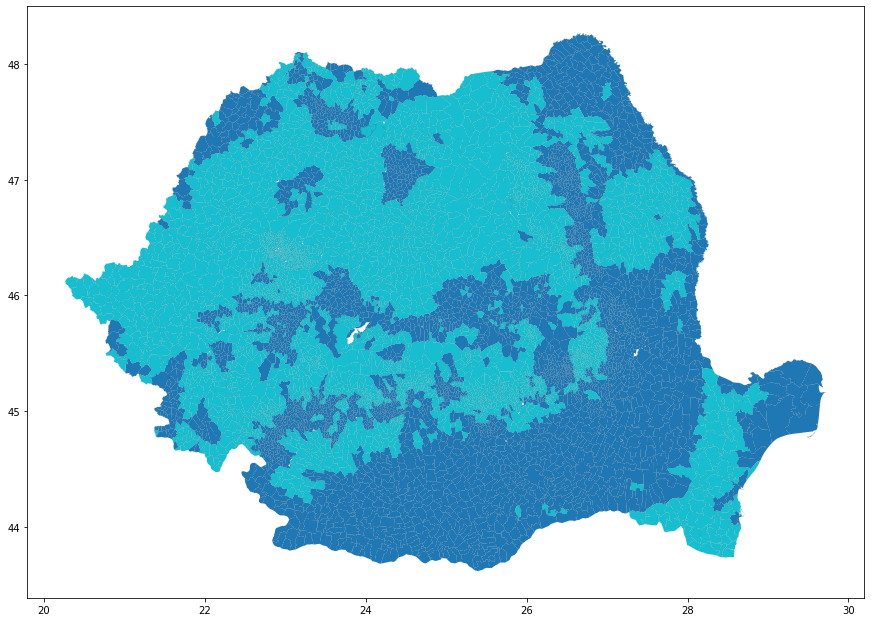

In [48]:
#Making a map with all villages
fig = plt.figure(1, figsize=(15,15)) 
ax = fig.add_subplot()
final.boundary.plot(ax=ax, color='Black', linewidth=.02)
final.plot(ax=ax, column = 'status')

In [49]:
#Creating a polygon for the villages that were collectivized to
#differentiate between real and predicted data
actual_data = final[final['collect'].isin([0, 1])]
actual_data['group_dis'] = "actual villages"
actual_data

/Users/bgpopescu/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Input_FID,Join_Count,TARGET_FID,uniqueID,raion_1960,raion_1962,commune_1960,commune_1962,village_1960,village_1962,...,sq_mean_point,geometry,data_available,UID,point_x,point_y,collect,col,status,group_dis
0,453.0,1.0,453.0,113.0,None,Horezu,None,Roești,None,Frasina,...,1.000000,"MULTIPOLYGON Z (((24.07293 44.91715 0.00000, 2...",Data Available,0,24.064119,44.922811,1,1,Collectivized,actual villages
1,451.0,1.0,451.0,111.0,None,Horezu,None,Roești,None,Cueni,...,1.000000,"MULTIPOLYGON Z (((24.10050 44.89461 0.00000, 2...",Data Available,1,24.085466,44.887799,1,1,Collectivized,actual villages
2,455.0,1.0,455.0,108.0,None,Horezu,None,Roești,None,Ciocîltei,...,1.000000,"MULTIPOLYGON Z (((24.09667 44.94828 0.00000, 2...",Data Available,2,24.084851,44.944439,1,1,Collectivized,actual villages
3,457.0,1.0,457.0,109.0,None,Horezu,None,Roești,None,Bălașa,...,1.000000,"MULTIPOLYGON Z (((24.06904 44.94153 0.00000, 2...",Data Available,3,24.059126,44.935628,1,1,Collectivized,actual villages
4,452.0,1.0,452.0,110.0,None,Horezu,None,Roești,None,Băjenari,...,1.000000,"MULTIPOLYGON Z (((24.08326 44.93335 0.00000, 2...",Data Available,4,24.081036,44.922596,1,1,Collectivized,actual villages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5446,1665.0,1.0,1665.0,2829.0,None,Hateg,None,Bretea Romînă,None,Covragiu,...,1.857143,"MULTIPOLYGON Z (((23.06420 45.58841 0.00000, 2...",Data Available,5450,23.033889,45.614787,1,1,Collectivized,actual villages
5447,1674.0,1.0,1674.0,2831.0,None,Hateg,None,Bretea Romînă,None,Vîlcelele Bune,...,1.857143,"MULTIPOLYGON Z (((23.08124 45.62508 0.00000, 2...",Data Available,5451,23.068249,45.648021,1,1,Collectivized,actual villages
5448,1672.0,1.0,1672.0,2832.0,None,Hateg,None,Bretea Romînă,None,Vîlcelele Rele,...,1.285714,"MULTIPOLYGON Z (((23.08262 45.66935 0.00000, 2...",Data Available,5452,23.053693,45.671500,1,1,Collectivized,actual villages
5449,1673.0,1.0,1673.0,2837.0,None,Hateg,None,Bretea Streiului,None,Ruși,...,1.142857,"MULTIPOLYGON Z (((23.00480 45.70388 0.00000, 2...",Data Available,5453,22.986297,45.693762,1,1,Collectivized,actual villages


In [50]:
#Dissolving polygons
#Takes about 2 mins
actual_data_one = actual_data.dissolve(by='group_dis')
actual_data_one

,geometry,Input_FID,Join_Count,TARGET_FID,uniqueID,raion_1960,raion_1962,commune_1960,commune_1962,village_1960,...,sq7_point,sq_mean,sq_mean_point,data_available,UID,point_x,point_y,collect,col,status
group_dis,,,,,,,,,,,,,,,,,,,,,
actual villages,"MULTIPOLYGON Z (((22.22886 44.55640 0.00000, 2...",453.0,1.0,453.0,113.0,Codlea,Horezu,Hălchiu,Roești,Hălchiu,...,1,1.0,1.0,Data Available,0,24.064119,44.922811,1,1,Collectivized


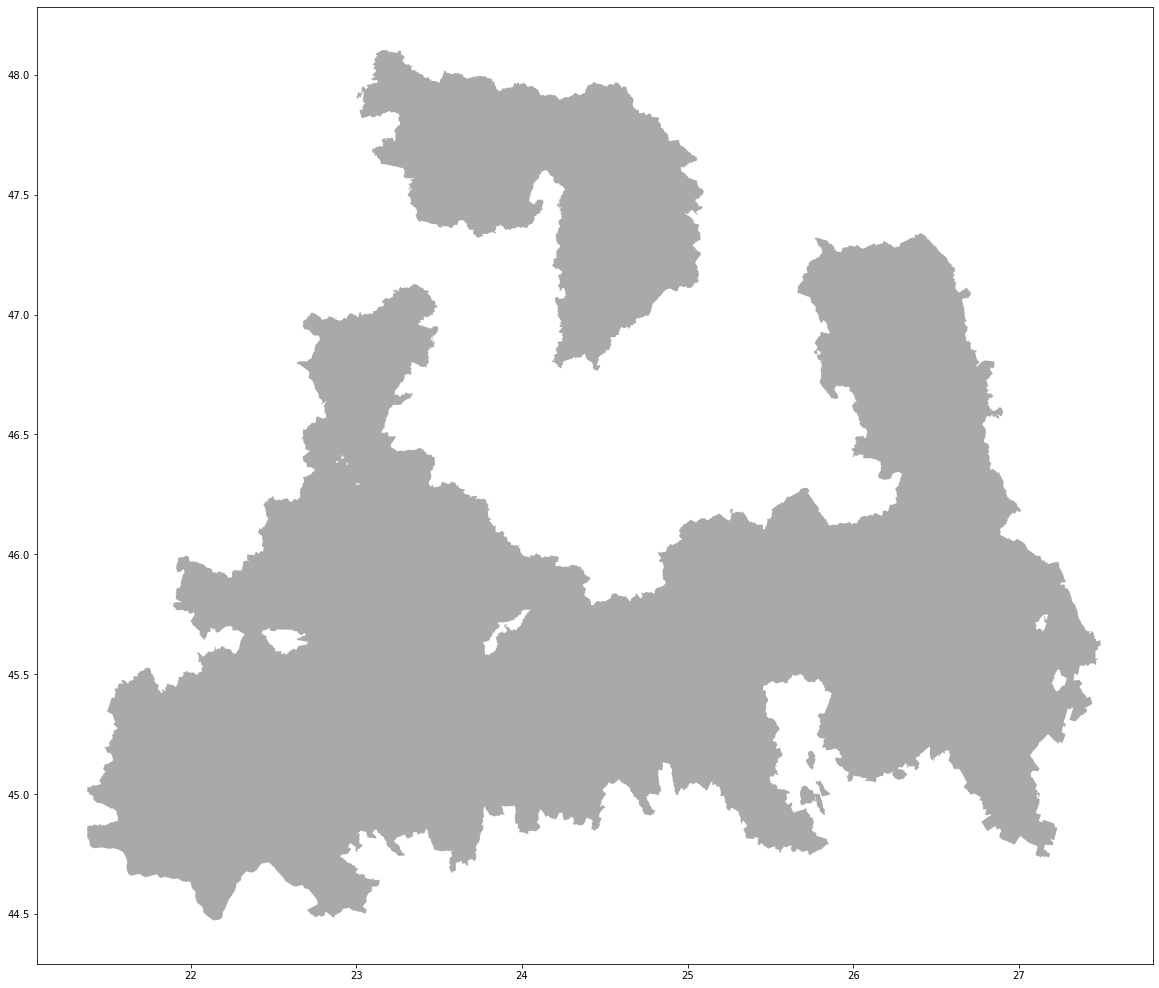

In [51]:
#Examining the resulting polyon
actual_data_one.plot(color="DarkGray")

In [52]:
final.columns

Index(['Input_FID', 'Join_Count', 'TARGET_FID', 'uniqueID', 'raion_1960',
       'raion_1962', 'commune_1960', 'commune_1962', 'village_1960',
       'village_1962',
       ...
       'sq_mean', 'sq_mean_point', 'geometry', 'data_available', 'UID',
       'point_x', 'point_y', 'collect', 'col', 'status'],
      dtype='object', length=110)

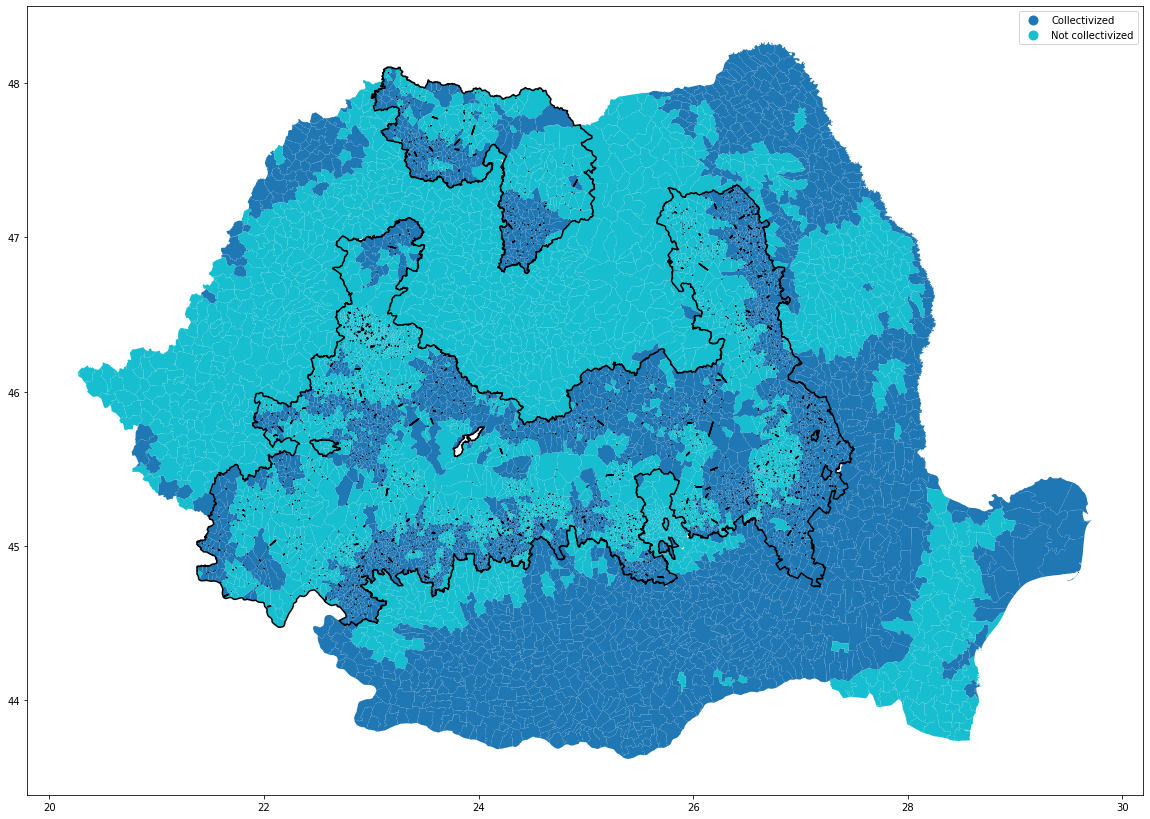

In [54]:
#Mapping final Data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
f, ax = plt.subplots()
actual_data_one.boundary.plot(ax=ax, color = 'Black')
x_fig = final.plot(ax=ax, column = "status", legend=True)
x_fig

plt.savefig('collect_pred_2.jpg')
#Black line encircles the actual data
#What is outside the black line represents predictions

In [ ]:
#Mapping with SVC

In [55]:
#Step3: Import the class
from sklearn import svm
# instantiate the model (using the default parameters)
clf = svm.SVC()
# fit the model with data
#.values will give the values in an array. (shape: (n,1)
#.ravel will convert that array shape to (n, )
clf.fit(X_scaled, y.values.ravel())

SVC()

In [69]:
#Scaling (standardizing) all the independent variables
#To ensure that the gradient descent moves smoothly towards the minima and 
#that the steps for gradient descent are updated at the same rate for all 
#the features, we scale the data before feeding it to the model.
#Scaling is good when data is vastly spread out.
X_new_scaled = preprocessing.scale(X_new.drop(["UID", 'preds'], axis=1))
X_new.shape, X_new_scaled.shape, X_scaled.shape

((2081, 15), (2081, 13), (5338, 13))

In [70]:
# make a prediction on out-of-sample data
clf.fit(X_scaled, y.values.ravel())

SVC()

In [71]:
y_hats = clf.predict(X_new_scaled)

In [72]:
#Counting 0 and 1 in predictions
unique, counts = np.unique(y_hats, return_counts=True)
dict(zip(unique, counts))

{0: 1019, 1: 1062}

In [73]:
#Adding predictions to the out-of-sample data
X_new['preds'] = y_hats
X_new

,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID,preds
138,308.357143,1.404589,9.467262,47.529762,1,1,1,2,1,1,1,25.924836,45.101543,138,1
139,300.071429,1.100574,9.551190,47.425595,1,1,1,1,1,1,1,25.902736,45.086632,139,0
140,252.000000,0.659051,9.761111,47.250000,1,1,1,2,1,1,1,25.949930,45.080627,140,1
206,590.250000,2.099852,8.335417,51.031250,1,1,1,1,1,1,1,25.639025,45.172690,206,0
207,504.888889,2.878028,8.598148,50.694444,1,1,1,1,1,1,1,25.672223,45.171875,207,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7419,264.869919,1.537478,9.388279,43.844851,1,1,1,1,1,1,1,27.083658,46.037755,7419,0
7420,82.288889,0.750335,10.075741,42.629630,1,1,1,1,2,1,1,27.194820,46.002826,7420,1
7421,231.278912,1.368029,9.493651,43.541950,1,1,1,1,1,1,1,27.090595,46.082302,7421,1
7422,170.074468,2.059208,9.648050,43.706560,1,1,1,1,1,1,1,27.307082,46.152678,7422,1


In [74]:
#Appending the out-of-sample data with predictions to the data where 
#the treatment is not null 
#(sample for which we know which villages where collectivized and which ones were not)
orig_and_predictions = df.append(X_new, ignore_index=True, sort=False)
orig_and_predictions

,collect,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID,preds
0,1.0,320.000000,0.672766,10.000000,55.027778,1,1,1,1,1,1,1,24.064119,44.922811,0,NaN
1,1.0,393.000000,0.961969,9.946667,54.866667,1,1,1,1,1,1,1,24.085466,44.887799,1,NaN
2,1.0,393.500000,1.735723,9.868750,55.145833,1,1,1,1,1,1,1,24.084851,44.944439,2,NaN
3,1.0,324.500000,1.223942,9.912500,55.097222,1,1,1,1,1,1,1,24.059126,44.935628,3,NaN
4,1.0,383.500000,2.723302,10.041667,54.736111,1,1,1,1,1,1,1,24.081036,44.922596,4,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,NaN,264.869919,1.537478,9.388279,43.844851,1,1,1,1,1,1,1,27.083658,46.037755,7419,0.0
7415,NaN,82.288889,0.750335,10.075741,42.629630,1,1,1,1,2,1,1,27.194820,46.002826,7420,1.0
7416,NaN,231.278912,1.368029,9.493651,43.541950,1,1,1,1,1,1,1,27.090595,46.082302,7421,1.0
7417,NaN,170.074468,2.059208,9.648050,43.706560,1,1,1,1,1,1,1,27.307082,46.152678,7422,1.0


In [75]:
#Creating a variable that contains both predictions and original collectivization variable
orig_and_predictions["col"]=None
orig_and_predictions.loc[orig_and_predictions['collect'] == 1, 'col'] = 1
orig_and_predictions.loc[orig_and_predictions['collect'] == 0, 'col'] = 0
orig_and_predictions.loc[orig_and_predictions['preds'] == 1, 'col'] = 1
orig_and_predictions.loc[orig_and_predictions['preds'] == 0, 'col'] = 0
orig_and_predictions

,collect,elev,slope,tavg_mean,prec_mean,sq1_point,sq2_point,sq3_point,sq4_point,sq5_point,sq6_point,sq7_point,point_x,point_y,UID,preds,col
0,1.0,320.000000,0.672766,10.000000,55.027778,1,1,1,1,1,1,1,24.064119,44.922811,0,NaN,1
1,1.0,393.000000,0.961969,9.946667,54.866667,1,1,1,1,1,1,1,24.085466,44.887799,1,NaN,1
2,1.0,393.500000,1.735723,9.868750,55.145833,1,1,1,1,1,1,1,24.084851,44.944439,2,NaN,1
3,1.0,324.500000,1.223942,9.912500,55.097222,1,1,1,1,1,1,1,24.059126,44.935628,3,NaN,1
4,1.0,383.500000,2.723302,10.041667,54.736111,1,1,1,1,1,1,1,24.081036,44.922596,4,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,NaN,264.869919,1.537478,9.388279,43.844851,1,1,1,1,1,1,1,27.083658,46.037755,7419,0.0,0
7415,NaN,82.288889,0.750335,10.075741,42.629630,1,1,1,1,2,1,1,27.194820,46.002826,7420,1.0,1
7416,NaN,231.278912,1.368029,9.493651,43.541950,1,1,1,1,1,1,1,27.090595,46.082302,7421,1.0,1
7417,NaN,170.074468,2.059208,9.648050,43.706560,1,1,1,1,1,1,1,27.307082,46.152678,7422,1.0,1


In [76]:
#Saving only this newly created variable containing both predictions and original data
df1 = orig_and_predictions[['UID', 'col']]
df1

,UID,col
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
7414,7419,0
7415,7420,1
7416,7421,1
7417,7422,1


In [77]:
#Merging this new dataframe with the initial dataset
final = pd.merge(soil, df1, on="UID")
final["status"]=None
final.loc[final['col'] == 1, 'status'] = "Collectivized"
final.loc[final['col'] == 0, 'status'] = "Not collectivized"
final

,Input_FID,Join_Count,TARGET_FID,uniqueID,raion_1960,raion_1962,commune_1960,commune_1962,village_1960,village_1962,...,sq_mean,sq_mean_point,geometry,data_available,UID,point_x,point_y,collect,col,status
0,453.0,1.0,453.0,113.0,None,Horezu,None,Roești,None,Frasina,...,NaN,1.000000,"MULTIPOLYGON Z (((24.07293 44.91715 0.00000, 2...",Data Available,0,24.064119,44.922811,1,1,Collectivized
1,451.0,1.0,451.0,111.0,None,Horezu,None,Roești,None,Cueni,...,NaN,1.000000,"MULTIPOLYGON Z (((24.10050 44.89461 0.00000, 2...",Data Available,1,24.085466,44.887799,1,1,Collectivized
2,455.0,1.0,455.0,108.0,None,Horezu,None,Roești,None,Ciocîltei,...,NaN,1.000000,"MULTIPOLYGON Z (((24.09667 44.94828 0.00000, 2...",Data Available,2,24.084851,44.944439,1,1,Collectivized
3,457.0,1.0,457.0,109.0,None,Horezu,None,Roești,None,Bălașa,...,NaN,1.000000,"MULTIPOLYGON Z (((24.06904 44.94153 0.00000, 2...",Data Available,3,24.059126,44.935628,1,1,Collectivized
4,452.0,1.0,452.0,110.0,None,Horezu,None,Roești,None,Băjenari,...,NaN,1.000000,"MULTIPOLYGON Z (((24.08326 44.93335 0.00000, 2...",Data Available,4,24.081036,44.922596,1,1,Collectivized
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7414,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.000000,1.000000,"MULTIPOLYGON Z (((26.96038 46.07917 0.00000, 2...",Data Not Available,7419,27.083658,46.037755,None,0,Not collectivized
7415,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.142857,1.142857,"MULTIPOLYGON Z (((27.23861 45.96791 0.00000, 2...",Data Not Available,7420,27.194820,46.002826,None,1,Collectivized
7416,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.000000,1.000000,"MULTIPOLYGON Z (((27.20619 46.07192 0.00000, 2...",Data Not Available,7421,27.090595,46.082302,None,1,Collectivized
7417,NaN,NaN,NaN,NaN,None,None,None,None,None,None,...,1.000000,1.000000,"MULTIPOLYGON Z (((27.36554 46.13712 0.00000, 2...",Data Not Available,7422,27.307082,46.152678,None,1,Collectivized


In [78]:
#Creating a polygon for the villages that were collectivized to
#differentiate between real and predicted data
actual_data = final[final['collect'].isin([0, 1])]
actual_data['group_dis'] = "actual villages"
actual_data

/Users/bgpopescu/opt/anaconda3/lib/python3.8/site-packages/geopandas/geodataframe.py:853: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,Input_FID,Join_Count,TARGET_FID,uniqueID,raion_1960,raion_1962,commune_1960,commune_1962,village_1960,village_1962,...,sq_mean_point,geometry,data_available,UID,point_x,point_y,collect,col,status,group_dis
0,453.0,1.0,453.0,113.0,None,Horezu,None,Roești,None,Frasina,...,1.000000,"MULTIPOLYGON Z (((24.07293 44.91715 0.00000, 2...",Data Available,0,24.064119,44.922811,1,1,Collectivized,actual villages
1,451.0,1.0,451.0,111.0,None,Horezu,None,Roești,None,Cueni,...,1.000000,"MULTIPOLYGON Z (((24.10050 44.89461 0.00000, 2...",Data Available,1,24.085466,44.887799,1,1,Collectivized,actual villages
2,455.0,1.0,455.0,108.0,None,Horezu,None,Roești,None,Ciocîltei,...,1.000000,"MULTIPOLYGON Z (((24.09667 44.94828 0.00000, 2...",Data Available,2,24.084851,44.944439,1,1,Collectivized,actual villages
3,457.0,1.0,457.0,109.0,None,Horezu,None,Roești,None,Bălașa,...,1.000000,"MULTIPOLYGON Z (((24.06904 44.94153 0.00000, 2...",Data Available,3,24.059126,44.935628,1,1,Collectivized,actual villages
4,452.0,1.0,452.0,110.0,None,Horezu,None,Roești,None,Băjenari,...,1.000000,"MULTIPOLYGON Z (((24.08326 44.93335 0.00000, 2...",Data Available,4,24.081036,44.922596,1,1,Collectivized,actual villages
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5446,1665.0,1.0,1665.0,2829.0,None,Hateg,None,Bretea Romînă,None,Covragiu,...,1.857143,"MULTIPOLYGON Z (((23.06420 45.58841 0.00000, 2...",Data Available,5450,23.033889,45.614787,1,1,Collectivized,actual villages
5447,1674.0,1.0,1674.0,2831.0,None,Hateg,None,Bretea Romînă,None,Vîlcelele Bune,...,1.857143,"MULTIPOLYGON Z (((23.08124 45.62508 0.00000, 2...",Data Available,5451,23.068249,45.648021,1,1,Collectivized,actual villages
5448,1672.0,1.0,1672.0,2832.0,None,Hateg,None,Bretea Romînă,None,Vîlcelele Rele,...,1.285714,"MULTIPOLYGON Z (((23.08262 45.66935 0.00000, 2...",Data Available,5452,23.053693,45.671500,1,1,Collectivized,actual villages
5449,1673.0,1.0,1673.0,2837.0,None,Hateg,None,Bretea Streiului,None,Ruși,...,1.142857,"MULTIPOLYGON Z (((23.00480 45.70388 0.00000, 2...",Data Available,5453,22.986297,45.693762,1,1,Collectivized,actual villages


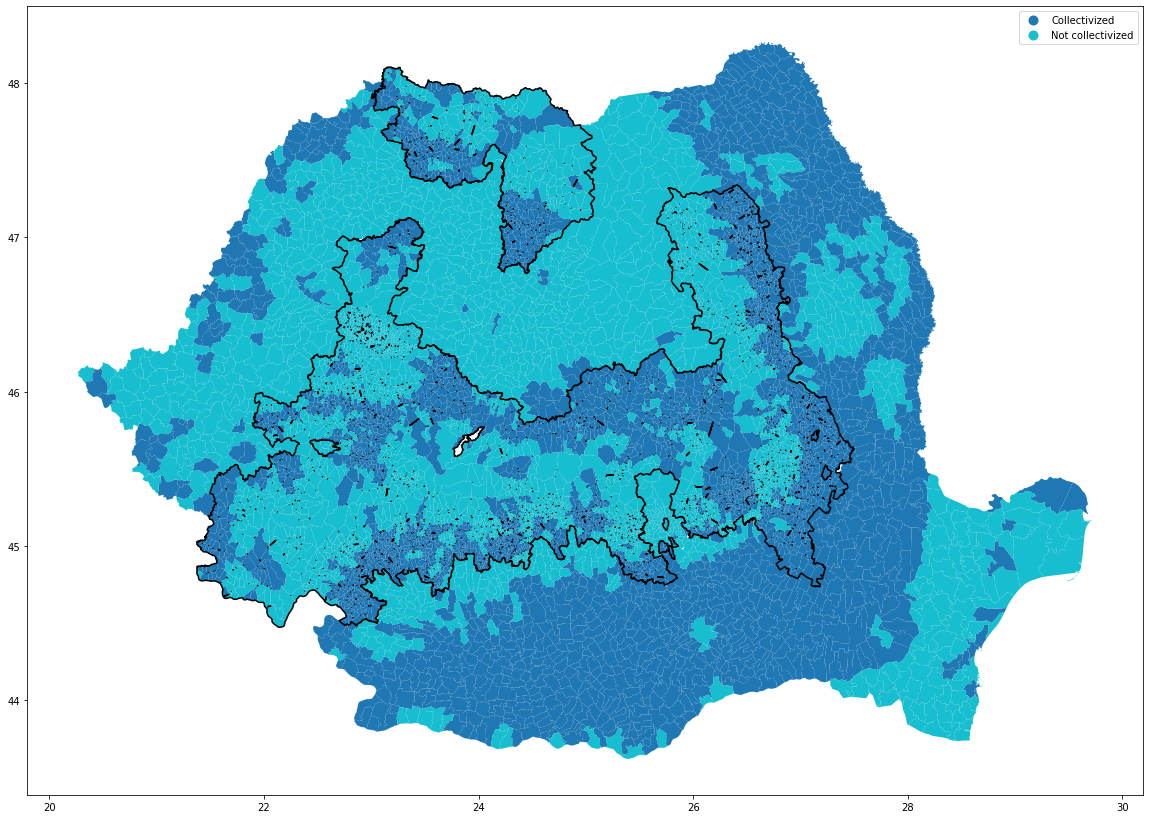

In [80]:
#Mapping final Data
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 20]
f, ax = plt.subplots()
actual_data_one.boundary.plot(ax=ax, color = 'Black')
fig_svm = final.plot(ax=ax, column = "status", legend=True)
fig_svm

plt.savefig('collect_pred_svc.jpg')
#Black line encircles the actual data
#What is outside the black line represents predictions